In [8]:
# Linear-Regression - Prediction of Sell price of cars
# Ref : ChatGpt 3

import pandas as pd
from io import StringIO
import io
import requests
import json
from io import FileIO
from json import loads, dumps
# import csv
import matplotlib.pyplot as plt

# DataSet : https://github.com/Rimbik/ai-nextGen/blob/main/linear_regression/sample_dataset/realestate_ds.csv
url = "https://raw.githubusercontent.com/Rimbik/ai-nextGen/refs/heads/main/linear_regression/sample_dataset/realestate_ds.csv"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

df

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816700
1,2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.135386
2,3,232.998485,1,3,2,1923,1,0,14,2.911442,6.904599,464478.696880
3,4,199.664621,5,2,2,1918,0,0,17,2.070949,8.284019,583105.656000
4,5,89.004660,4,3,3,1999,1,0,34,1.523278,14.648277,619879.142523
...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,138.338057,2,2,2,1967,1,0,16,4.296086,5.562583,488496.350722
496,497,195.914028,2,3,1,1977,0,1,45,7.406261,2.845105,657736.921717
497,498,69.433659,1,1,2,2004,0,0,18,8.629724,6.263264,405324.950201
498,499,293.598702,5,1,3,1940,1,0,41,5.318891,16.990684,773035.968000


In [15]:
# VIF Technique (Variance Inflation Factor - VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def calculate_vif(X):
    vif_data = pd.DataFrame()

    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data


vif_df = calculate_vif(df)

# drop features with high VIF values
# RULES : to identify high VIF
  # A) VIF > 10: Serious multicollinearity
  # B) VIF > 4 or 5: Moderate to high multicollinearity
  # C) VIF = 1: The predictor is not correlated with other variables

# Find >>
# A : features above 10 are considered to indicate serious multicollinearity
    # Price = This we will predict
    # serious multicollinearity [Year_Built, Square_Feet, Number_Bedroom]
# B : features that are greater than 4 or 5
    # [Garage_Size, Num_Bedrooms, Num_Floors, Num_Bathrooms]
# VIF = 1: The predictor is not correlated with other variables
    # Nil

# ---------------------------------------------------------------------------#
vif_df = vif_df.sort_values(by='VIF', ascending=False)
vif_df


,feature,VIF
11,Price,116.260116
5,Year_Built,48.649395
1,Square_Feet,17.293680
2,Num_Bedrooms,14.259787
8,Garage_Size,8.187263
3,Num_Bathrooms,7.914554
4,Num_Floors,7.779240
10,Distance_to_Center,4.931112
9,Location_Score,4.550873
0,ID,4.066465


In [19]:
new_df = df.drop(['Year_Built', 'Square_Feet', 'Num_Bedrooms', 'Garage_Size', 'Num_Floors', 'Num_Bathrooms'], axis=1)
new_df


,ID,Has_Garden,Has_Pool,Location_Score,Distance_to_Center,Price
0,1,1,1,8.297631,5.935734,602134.816700
1,2,0,1,6.061466,10.827392,591425.135386
2,3,1,0,2.911442,6.904599,464478.696880
3,4,0,0,2.070949,8.284019,583105.656000
4,5,1,0,1.523278,14.648277,619879.142523
...,...,...,...,...,...,...
495,496,1,0,4.296086,5.562583,488496.350722
496,497,0,1,7.406261,2.845105,657736.921717
497,498,0,0,8.629724,6.263264,405324.950201
498,499,1,0,5.318891,16.990684,773035.968000


In [20]:
vif_df = calculate_vif(new_df)
vif_df


,feature,VIF
0,ID,3.692797
1,Has_Garden,2.196130
2,Has_Pool,2.078434
3,Location_Score,4.079503
4,Distance_to_Center,4.193765
5,Price,10.082112


In [34]:
# Progrmatically identify colums to be dropped
def tag_columns_tobeDropped(df):
    mydf = df.copy()
    vif_df = calculate_vif(mydf)
    vif_df["candrop"] = ""
    vif_df["drop_reason"] = "-"

    vif_df = vif_df.sort_values(by='VIF', ascending=False)

    for index, row in vif_df.iterrows():
          if row["VIF"] > 10:
              vif_df.at[index, "candrop"] = "Y"
              vif_df.at[index, "drop_reason"] = "Serious multicollinearity"

          elif row["VIF"] > 4:
              vif_df.at[index, "candrop"] = "Y"
              vif_df.at[index, "drop_reason"] = "Moderate to high multicollinearity"

          elif row["VIF"] == 1:
              vif_df.at[index, "candrop"] = "Y"
              vif_df.at[index, "drop_reason"] = "Not correlated with other variables"

          else:
              vif_df.at[index, "candrop"] = "N"
              vif_df.at[index, "drop_reason"] = "No need to drop"

    return vif_df


vif_df_indicator = tag_columns_tobeDropped(df)
vif_df_indicator



,feature,VIF,candrop,drop_reason
11,Price,116.260116,Y,Serious multicollinearity
5,Year_Built,48.649395,Y,Serious multicollinearity
1,Square_Feet,17.293680,Y,Serious multicollinearity
2,Num_Bedrooms,14.259787,Y,Serious multicollinearity
8,Garage_Size,8.187263,Y,Moderate to high multicollinearity
3,Num_Bathrooms,7.914554,Y,Moderate to high multicollinearity
4,Num_Floors,7.779240,Y,Moderate to high multicollinearity
10,Distance_to_Center,4.931112,Y,Moderate to high multicollinearity
9,Location_Score,4.550873,Y,Moderate to high multicollinearity
0,ID,4.066465,Y,Moderate to high multicollinearity


In [52]:
tuned_df = vif_df_indicator[vif_df_indicator["candrop"] != "Y"]
df_toTrain = df.filter(['Has_Garden','Has_Pool','Price'], axis=1)
df_toTrain




,Has_Garden,Has_Pool,Price
0,1,1,602134.816700
1,0,1,591425.135386
2,1,0,464478.696880
3,0,0,583105.656000
4,1,0,619879.142523
...,...,...,...
495,1,0,488496.350722
496,0,1,657736.921717
497,0,0,405324.950201
498,1,0,773035.968000


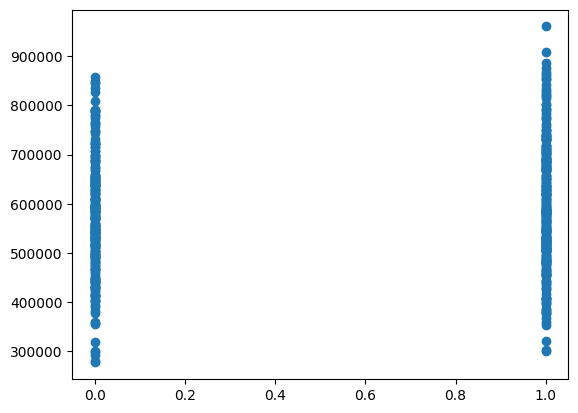

In [53]:
import matplotlib.pyplot as plt
plt.scatter(df_toTrain['Has_Garden'],df['Price'])
# DOES NOT LOOK LIKE A GOOD CORRELATION if considering VIF Rules
